In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


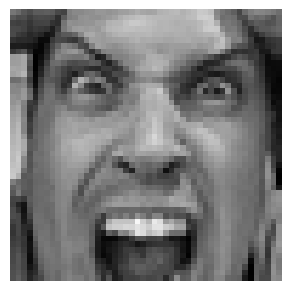

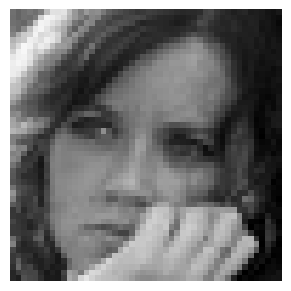

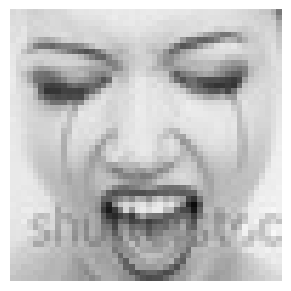

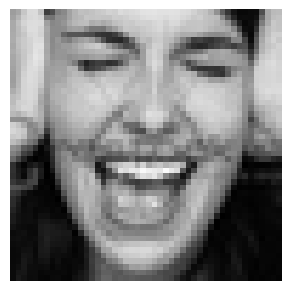

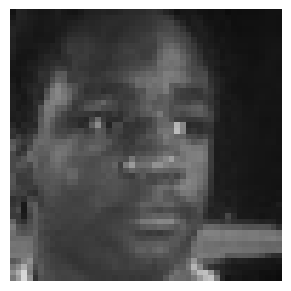

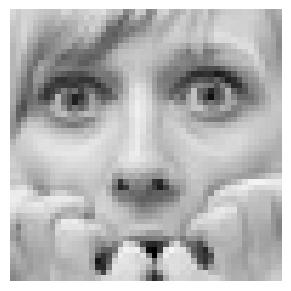

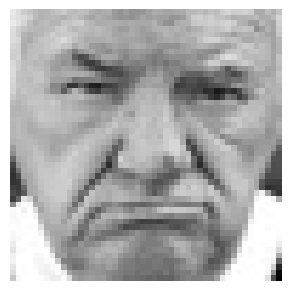

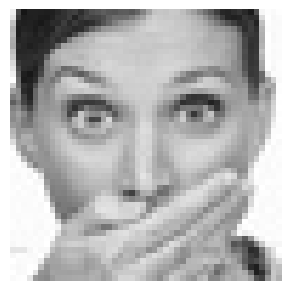

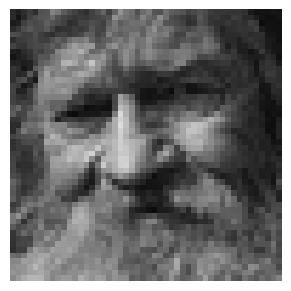

In [3]:
images = glob("train/**/**")
for i in range (9):
    image = random.choice(images) 
    plt.figure(figsize=(12,12)) 
    plt.subplot(331+i) 
    plt.imshow(cv2.imread(image));plt.axis('off')

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28695 images belonging to 7 classes.
Found 7154 images belonging to 7 classes.


In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))
    
    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)
    
    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor ="val_accuracy", save_weights_only = True, mode = "max", verbose =1)
callbacks = (checkpoint,)

In [10]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs, 
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


C:\Users\LENOVO\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3294 - loss: 1.8522
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 220s 480ms/step - accuracy: 0.3295 - loss: 1.8518 - val_accuracy: 0.3650 - val_loss: 1.6464
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:28 467ms/step - accuracy: 0.3750 - loss: 1.6026
Epoch 2: saving model to model_weights.weights.h5


C:\Users\LENOVO\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3750 - loss: 1.6026 - val_accuracy: 0.4800 - val_loss: 1.5106
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.4845 - loss: 1.3520
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 218s 485ms/step - accuracy: 0.4845 - loss: 1.3520 - val_accuracy: 0.4268 - val_loss: 1.5181
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:30 471ms/step - accuracy: 0.5000 - loss: 1.3253
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 1.3253 - val_accuracy: 0.5200 - val_loss: 1.1859
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5633 - loss: 1.1813
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 210s 468ms/step - accuracy: 0.5633 - loss: 1.1813 - val_accuracy: 0.4641 - val_loss: 1.4324
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:32 475ms/step - accuracy: 0.5469 - loss: 1.1381
Epoch 6: saving mo

In [11]:
model.evaluate(validation_generator)

112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.4986 - loss: 1.5377


[1.584215521812439, 0.48630136251449585]

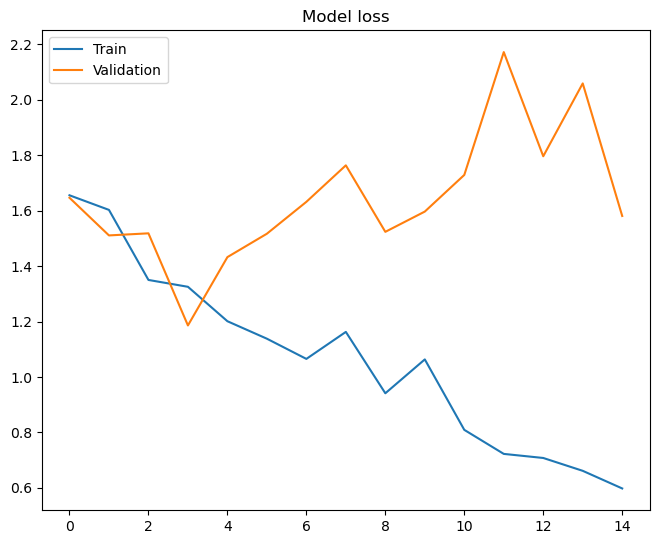

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.legend(["Train","Validation"],loc = "upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

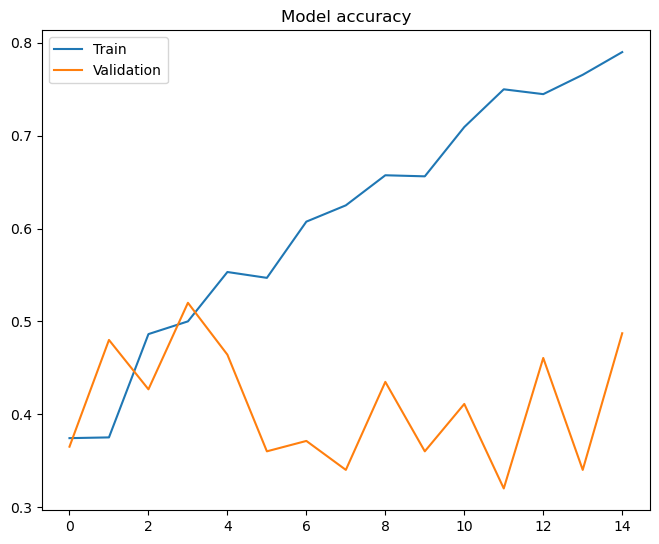

In [15]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.legend(["Train","Validation"],loc = "upper left")
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [16]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)